In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib
import h5py
import os

import calculation.MeanFieldv2 as MFv2
import calculation.CurrentMeirv2 as CsMv2
import calculation.SusceptibilitySimpv2 as Susceptv2

import settings.Constants as const

from matplotlib.colors import LinearSegmentedColormap


viridis_mod = LinearSegmentedColormap.from_list(
    "viridis_mod", plt.cm.viridis(np.linspace(0, 0.8, 256))
)

plasma_mod = LinearSegmentedColormap.from_list(
    "plasma_mod", plt.cm.plasma(np.linspace(0, 0.85, 256))
)

In [2]:

### Order Parameter and Mean-Field Current Calculation

### Parameters
Tvalue = 0.5
couplingValue = 0.7

size_vec = 100

lambdaSpacePlot = np.linspace(0.0, 1.8, size_vec)
voltageSpacePlot = np.linspace(0.0, 2.0, size_vec)

shiftVoltage = 0.4

colorsLambda = plasma_mod(np.linspace(0.1, 0.8, 3))
colorsVoltage = viridis_mod(np.linspace(0, 0.85, 4))


## Initial Conditions
phiConstantInit = 0.5
phiLambdaInit = 0.9

In [3]:
### First PLot

phiValue = 0.0001
boundaryLine = np.zeros_like(voltageSpacePlot)

pbar = tqdm(total=len(voltageSpacePlot))
for i in range(len(voltageSpacePlot)):
    voltageValue = voltageSpacePlot[i]
    result = scipy.optimize.root(MFv2.computeMeanField, phiLambdaInit, args=(phiValue, voltageValue, Tvalue, MFv2.Impy, couplingValue), method='lm', tol=1e-6)
    boundaryLine[i] = result.x
    pbar.update(1)


pbar.close()


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/l6/sz7h_28d1vn668qy7qlhpvzw0000gn/T/ipykernel_26763/4101649005.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  boundaryLine[i] = result.x
100%|██████████| 100/100 [00:01<00:00, 81.89it/s]


Text(0, 0.5, '$\\lambda/\\Lambda$')

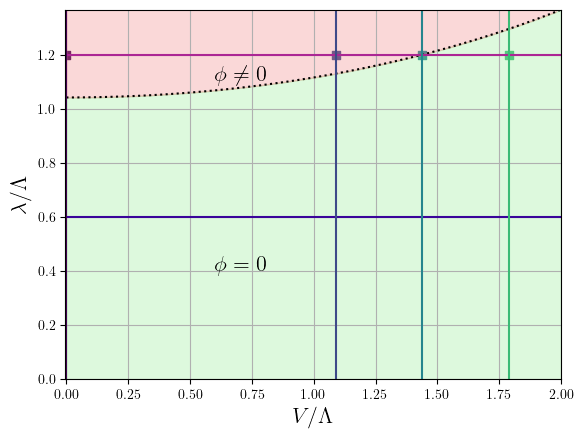

In [4]:
boundaryLineV_func = scipy.interpolate.interp1d(voltageSpacePlot, boundaryLine, kind='linear')
boundaryLineL_func = scipy.interpolate.interp1d(boundaryLine, voltageSpacePlot, kind='linear')


# lambdaSamples = np.array([0.6, boundaryLineV_func(0.0), 1.0])
lambdaSamples = np.array([0.6, 1.2])

voltageCriticalAux = boundaryLineL_func(lambdaSamples[-1])
shiftVoltage = 0.35
voltageSamples = np.array([0.0, voltageCriticalAux - shiftVoltage, voltageCriticalAux, voltageCriticalAux + shiftVoltage])


plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.plot(voltageSpacePlot, boundaryLine, color='black', linestyle='dotted')
plt.ylim(0, boundaryLine[-1])
plt.xlim(0, voltageSpacePlot[-1])
plt.xlabel(r'$V/\Lambda$', fontsize=16)
plt.ylabel(r'$\lambda/\Lambda$', fontsize=16)
plt.grid()

for i in range(len(lambdaSamples)):
    plt.axhline(y=lambdaSamples[i], color=colorsLambda[i])

for i in range(len(voltageSamples)):
    plt.axvline(x=voltageSamples[i], color=colorsVoltage[i])


for i in range(len(voltageSamples)):
    plt.scatter(voltageSamples[i], lambdaSamples[-1], color=colorsVoltage[i], marker='s')

limUpp = np.ones(len(voltageSpacePlot))*boundaryLine[-1]

plt.fill_between(voltageSpacePlot, boundaryLine, 0, where=(boundaryLine > 0), color='lightgreen', alpha=0.3)
plt.fill_between(voltageSpacePlot, boundaryLine, limUpp, where=(limUpp > boundaryLine), color='lightcoral', alpha=0.3)


plt.text(0.60, 1.1, r"$\phi \neq 0$", fontsize=16)
plt.text(0.60, 0.4, r"$\phi = 0$", fontsize=16)

plt.ylim(0, boundaryLine[-1])
plt.xlim(-0.005, voltageSpacePlot[-1])
plt.xlabel(r'$V/\Lambda$', fontsize=16)
plt.ylabel(r'$\lambda/\Lambda$', fontsize=16)
# plt.savefig('figures/PhaseDiagram.pdf')


In [5]:
def findCriticalPoint(phiSpace, lambdaSpace, eps=1e-2, shift=-1):
    
    phiCritical = np.zeros(phiSpace.shape[0])
    lambdaCritical = np.zeros(phiSpace.shape[0])
    
    for i in range(phiSpace.shape[0]):
        for j in range(phiSpace.shape[1]):
            
            if np.abs(phiSpace[i, j]) > eps:
                phiCritical[i] = phiSpace[i, j+shift]
                lambdaCritical[i] = lambdaSpace[j+shift]
                break

    return phiCritical, lambdaCritical



def findCriticalPointReverseOrder(phiSpace, lambdaSpace, eps=1e-2, shift=1):
    
    phiCritical = np.zeros(phiSpace.shape[0])
    lambdaCritical = np.zeros(phiSpace.shape[0])
    
    for i in range(phiSpace.shape[0]):
        for j in range(phiSpace.shape[1]-1, 0, -1):
            
            if np.abs(phiSpace[i, j]) > eps:
                phiCritical[i] = phiSpace[i, j+shift]
                lambdaCritical[i] = lambdaSpace[j+shift]
                break

    return phiCritical, lambdaCritical

In [6]:

### Perpective 1

phiMFSpace = np.zeros((len(voltageSamples), size_vec), dtype=float)

pbar = tqdm(total=len(voltageSamples)*size_vec, desc='Computing phi(lambda)')

for j in range(len(voltageSamples)):
    voltageValue = voltageSamples[j]
    for i in range(size_vec):
        lambdaValue = lambdaSpacePlot[i]
        result = scipy.optimize.root(MFv2.computeMFLambda, phiConstantInit, args=(lambdaValue, voltageValue, Tvalue, MFv2.Impy, couplingValue), method='lm', tol=1e-6)
        phiMFSpace[j,i] = result.x[0]
        
        pbar.update(1)

pbar.close()



Computing phi(lambda): 100%|██████████| 400/400 [00:21<00:00, 18.21it/s]


Text(0, 0.5, '$\\phi$')

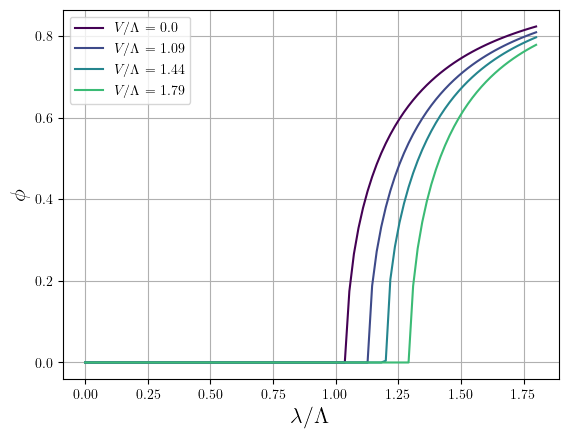

In [7]:
plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
for i in range(len(voltageSamples)):
    plt.plot(lambdaSpacePlot, phiMFSpace[i,:], label=r'$V/\Lambda$ = ' + str(round(voltageSamples[i],2)), color=colorsVoltage[i])

plt.legend()
plt.grid()
plt.xlabel(r'$\lambda/\Lambda$', fontsize=16)
plt.ylabel(r'$\phi$', fontsize=16)
# plt.savefig('figures/PhiLambda.pdf')

In [8]:
### Perspective 2

phiMFSpace2 = np.zeros((len(lambdaSamples), size_vec), dtype=float)
pbar = tqdm(total=len(lambdaSamples)*size_vec, desc='Computing phi(lambda)')

for j in range(len(lambdaSamples)):
    lambdaValue = lambdaSamples[j]
    for i in range(size_vec):
        voltageValue = voltageSpacePlot[i]
        result = scipy.optimize.root(MFv2.computeMFLambda, phiConstantInit, args=(lambdaValue, voltageValue, Tvalue, MFv2.Impy, couplingValue), method='lm', tol=1e-6)
        phiMFSpace2[j,i] = result.x[0]
        
        pbar.update(1)

pbar.close()

Computing phi(lambda): 100%|██████████| 200/200 [00:08<00:00, 24.09it/s]


[[0.00000000e+00 5.37412505e-01]
 [1.08936833e+00 3.80598614e-01]
 [1.43936833e+00 3.94889185e-02]
 [1.78936833e+00 6.90659854e-09]]


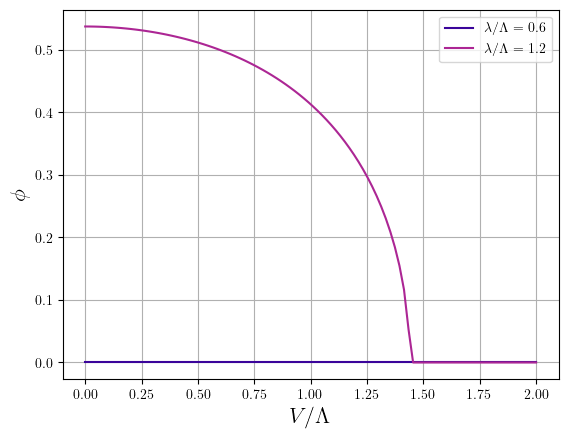

In [9]:

plt.figure()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
for i in range(lambdaSamples.shape[0]):
    plt.plot(voltageSpacePlot, phiMFSpace2[i,:], label=r'$\lambda/\Lambda$ = ' + str(round(lambdaSamples[i],2)), color=colorsLambda[i])

plt.legend()
plt.grid()
plt.xlabel(r'$V/\Lambda$', fontsize=16)
plt.ylabel(r'$\phi$', fontsize=16)
plt.savefig('figures/PhiVoltageTvalue.pdf')

phi_Lambda_func = scipy.interpolate.interp1d(voltageSpacePlot, phiMFSpace2[-1,:], kind='linear')

saddle_points_vec= np.array([(voltageSamples[i], phi_Lambda_func(voltageSamples[i])) for i in range(len(voltageSamples))])
print(saddle_points_vec)




In [10]:
### Perspective 3


# phiValue = 0.0001
# boundaryLine2 = np.zeros((voltageSamples.shape[0], size_vec), dtype=float)
# TSpacePlot = np.linspace(1e-5, 1.0, size_vec)

# pbar = tqdm(total=len(lambdaSpacePlot)*len(voltageSamples))

# for i in range(size_vec):
#     for j in range(len(voltageSamples)):
#         voltageValue = voltageSamples[j]
#         TvaluePlot = TSpacePlot[i]
#         result = scipy.optimize.root(MFv2.computeMeanField, phiLambdaInit, args=(phiValue, voltageValue, TvaluePlot, MFv2.Impy, couplingValue), method='lm', tol=1e-6)
#         boundaryLine2[j, i] = result.x
#         pbar.update(1)


# pbar.close()

In [11]:
# for i in range(len(voltageSamples)):
#     plt.plot(boundaryLine2[i,:], TSpacePlot, label=r'$V/\Lambda$ = ' + str(round(voltageSamples[i],2)), color=colorsVoltage[i])
# plt.xlabel(r'$\lambda/\Lambda$', fontsize=16)
# plt.ylabel(r'$T$', fontsize=16)
# plt.grid()

In [12]:

if os.path.exists(const.saddlePointFileTvalue):
    os.remove(const.saddlePointFileTvalue)

with h5py.File(const.saddlePointFileTvalue, 'w') as f:
    group = f.create_group('SaddlePoint')
    group.create_dataset('T', data=Tvalue)
    group.create_dataset('coupling', data=couplingValue)
    group.create_dataset('saddle_points', data=saddle_points_vec)
    group.create_dataset('voltageSpacePlot', data=voltageSpacePlot)
    group.create_dataset('lambdaSpacePlot', data=lambdaSpacePlot)
    group.create_dataset('phi-boundaryLine', data=boundaryLine)
    group.create_dataset('phi-Lambda', data=phiMFSpace)
    group.create_dataset('phi-Voltage', data=phiMFSpace2)
    group.create_dataset('lambdaSamples', data=lambdaSamples)
    group.create_dataset('voltageSamples', data=voltageSamples)
    group.create_dataset('colorsLambda', data=colorsLambda)
    group.create_dataset('colorsVoltage', data=colorsVoltage)

f.close()

In [13]:
print(Tvalue)

0.5
